# ContinuousMeasurementBayes
## Example

### With simulated experimental data

In [78]:
using Pkg
Pkg.activate(".");

using Plots
using LaTeXStrings
using HDF5
using Statistics
using StatsBase
using Random

include("fluo_cont_meas_sim.jl")
include("likelihood.jl")
include("likelihood_strong.jl")
include("fisher_cont_meas.jl")
include("load_data.jl");

In [72]:
# Define the parameters
T1 = 15.0
TD = 5.0
Trabi = 5.1
Tphi = 17.9

NTrajectories = 500

# Parameter dictionary to be passed to the functions
params = Dict( :Tfinal    => 20., # Final time
               :dt        => 0.1, # duration of infinitesimal time
               :Gamma1    => 1. / T1,   # Gamma fluoresence
               :GammaD    => 1. / TD,  # Gamma dephasing controllable
               :GammaPhi  => 1. / Tphi,  # Gamma dephasing not controllable
               :etavalF   => 0.14, # efficiency fluoresence heterodyne
               :etavalD   => 0.34, # efficiency dephasing homodyne
               :omegaTrue => 2 * pi / Trabi, # True value of omega
               :omegaMin  => 0., # minimum value of omega
               :omegaMax  => 2., # maximum value of omega
               :threshold => 0.375, # Threshold for discriminating between outcomes of final strong measurement
               :unconditional_timesteps => 3, # Steps with unconditional dynamics 
               :Nomega    => 500); # Resolution in omega for the Bayesian estimation

This function simulates the continuously monitored system.

In [73]:
@time simData = parallel_fluo_continuous_measurement_het_simulation(NTrajectories; params...) 

# The outcome is a NamedTuple
# (t, Ntime, dyHet1, dyHet2, dyDep, OutStrong, AvgZcondTrue)

  0.060769 seconds (205.71 k allocations: 39.940 MiB, 11.39% gc time)


(t = 0.1:0.1:20.0, Ntime = 200, dyHet1 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.0980749 0.184237 … -0.205545 0.453359; -0.645373 -0.0480283 … -0.147659 -0.0246023], dyHet2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.0886922 -0.198599 … 0.0950585 -0.427204; 0.391894 -0.278928 … 0.0225454 0.160881], dyDep = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.244292 0.562675 … 0.488574 -0.377572; -0.383546 -0.443179 … -0.49404 -0.364512], OutStrong = [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; 1.0 1.0 … 1.0 -1.0; -1.0 -1.0 … -1.0 1.0], AvgZcondTrue = [-0.913547 -0.893452 … 0.612351 0.47338; -0.913547 -0.893452 … 0.457376 0.315486; … ; -0.913547 -0.893452 … 0.647918 0.521207; -0.913547 -0.893452 … -0.572216 -0.634363])

In [74]:
# This runs the Bayesian estimation
@time simResult = likelihood_strong(simData; params...);

  6.675390 seconds (51.53 M allocations: 6.172 GiB, 12.82% gc time)


The following is a plot of the Bayesian and maximum-likelihood estimation as a function of time. The shaded area is the standard deviation of the Bayesian estimator

### Evaluating the Fisher information

In [54]:
# For the unconditional dynamics, we set zero efficiency
params_unconditional = copy(params)
params_unconditional[:etavalF] = 0.
params_unconditional[:etavalD] = 0.

#(tFisher, FisherAvgUncOmega15, QFisherAvgUncOmega15, FisherMAvgUncOmega15, QFisherEffUNCOmega15, FisherMEffUNCOmega15)
@time fisherUncResult = parallel_fluo_continuous_measurement_het_classic_initial0(10; Ntime=1000, params_unconditional...)
@time fisherResult = parallel_fluo_continuous_measurement_het_classic_initial0(5000; Ntime=1000, params...);

  0.146446 seconds (955.26 k allocations: 84.972 MiB, 16.62% gc time)
 70.558809 seconds (477.31 M allocations: 41.874 GiB, 13.94% gc time)


### Plotting results

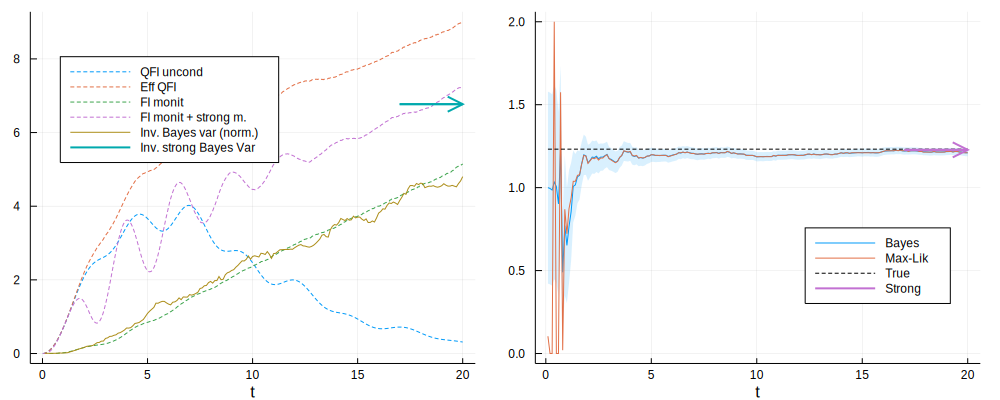

In [75]:
let res = simResult
    p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", style=:dash, legend=:topleft)
    plot!(fisherResult.t, fisherResult.QFisherEff, style=:dash, label="Eff QFI")
    plot!(fisherResult.t,  fisherResult.FisherAvg, style=:dash, label="FI monit")
    plot!(fisherResult.t, fisherResult.FisherMEff, style=:dash, label="FI monit + strong m.")
    plot!(res.t, res.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
    plot!([17, 20], fill(1. / (NTrajectories*(res.sigmaStrong[NTrajectories]^2)), 2), line = (:steppre, :arrow, 1, 2), label="Inv. strong Bayes Var")

    xlabel!("t")

    p2 = plot( res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash,  color=:black, label="True")
    plot!([17, 20], fill(res.omegaEstStrong[end], 2), line = (:steppre, :arrow, 1, 2), fillalpha=0.15, label="Strong")
    xlabel!("t")
    plot(p1, p2, size=(1000,400), layout=2)
end

The left plot shows the performance of the estimation vs the various information quantities defined in the paper (dashed lines): 

* **QFI uncond**: Quantum Fisher information for a final strong measurement after unconditional dynamics
* **FI monit**: FI corresponding to the monitoring strategy
* **FI monit + strong m.**: FI corresponding to the continuous monitoring + chosen final measurement
* **Eff. QFI**: Effective QFI as defined in the paper: FI for the continuous monitoring + QFI for final strong measurement

The solid line represent the inverse variance of the estimator for the continuous monitoring, and should saturate *FI monit*, while the arrow shows the inverse variance of the whole estimation procedure, including the final strong measurement, and should saturate the final point of *FI monit + strong m*.

The right plot shows the estimated value of the parameter with Bayes and maximum-likelihood estimator. The shaded area is the standard deviation of the Bayesian estimator.
The arrow shows the estimated value when performing the final strong measurement.

### Experimental data

In [79]:
filename = "093_exp=4_prepared.h5"

"093_exp=4_prepared.h5"

Load the whole data in memory, and preprocess it for the `likelihood_strong` function

In [80]:
@time experimental_data = load_z_data(filename);

(500000, 1)(200, 500000)(200, 500000)(200, 500000) 43.170264 seconds (654.59 k allocations: 8.916 GiB, 2.31% gc time)


We extract a subset of the data by randomly sampling the trajectories

In [82]:
expData = sample_data(NTrajectories, experimental_data)

(dyHet1 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.482634 0.0310956 … -0.0325254 -0.128242; 0.503756 0.211143 … 0.419246 -0.146737], dyHet2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.451874 0.422287 … -0.126128 0.0334246; 0.231959 -0.390673 … 0.191026 0.622759], dyDep = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.381324 0.0844231 … 0.38659 0.179245; 0.164962 0.196946 … -0.0919779 -0.323917], OutStrong = [-1.25307, -1.25888, 1.76348, 0.982399, -1.26954, -0.833916, 1.30655, -1.10238, -0.490281, -1.06342  …  -1.02408, 1.55747, 2.07087, 1.8902, 1.44598, -0.983586, 1.50448, 1.8448, 1.60582, 1.79799])

In [83]:
@time expResult = likelihood_strong(expData; params...);

  7.123577 seconds (52.99 M allocations: 6.232 GiB, 11.92% gc time)


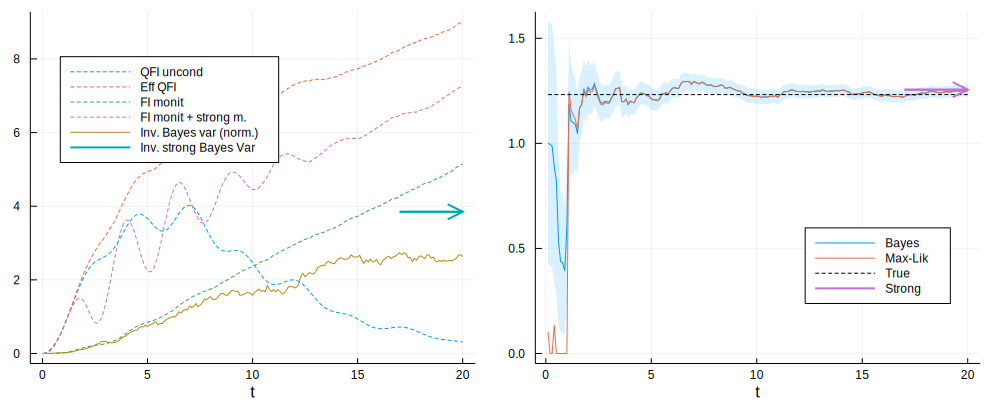

In [84]:
let res = expResult
    p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", style=:dash, legend=:topleft)
    plot!(fisherResult.t, fisherResult.QFisherEff, style=:dash, label="Eff QFI")
    plot!(fisherResult.t,  fisherResult.FisherAvg, style=:dash, label="FI monit")
    plot!(fisherResult.t, fisherResult.FisherMEff, style=:dash, label="FI monit + strong m.")
    plot!(res.t, res.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
    plot!([17, 20], fill(1. / (NTrajectories*(res.sigmaStrong[NTrajectories]^2)), 2), line = (:steppre, :arrow, 1, 2), label="Inv. strong Bayes Var")

    xlabel!("t")

    p2 = plot( res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash,  color=:black, label="True")
    plot!([17, 20], fill(res.omegaEstStrong[end], 2), line = (:steppre, :arrow, 1, 2), fillalpha=0.15, label="Strong")
    xlabel!("t")
    plot(p1, p2, size=(1000,400), layout=2)
end